# **Lab 7.1 Data Augmentation with PyTorch**

In [1]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset
from torch.nn import functional as F
import random
import cv2
import numpy as np
from skimage.util import random_noise
import matplotlib.pyplot as plt
import os

Complete the `load_data()` function that loads the image using `ImageFolder()` with the specific `transforms.compose()` provided below.
`load_data()` will return DataLoader() and print the information about the Dataset.

`transforms.Compose()` :
- `transforms.Resize()`
- `transforms.ToTensor()`
- `transforms.Pad()`
- `transforms.RandomAffine(degrees=45, translate=(0.1, 0.1),scale=(0.8, 1.2), shear=45)`
- `transforms.CenterCrop()`

Resource : [`transforms.Compose()`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html#compose), [`torchvision.transforms v1`](<https://pytorch.org/vision/stable/transforms.html#v1-api-reference:~:text=custom)%20tv_tensor%20type.-,V1%20API%20Reference,-Geometry>), [`ImageFolder`](https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html), [`Dataloader`](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#:~:text=Preparing%20your%20data%20for%20training%20with%20DataLoaders)

In [2]:
def load_data(path):
    ### START CODE HERE ###
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Pad(223, padding_mode='reflect'), 
        transforms.RandomAffine(degrees=45, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=45),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])

    dataset = ImageFolder(path, transform=transform)

    data_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=16, pin_memory=True)

    return data_loader

    ### END CODE HERE ###

Use your load_data() function to load the dataset in the cell below. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
📃Train Dataset:
	Number of images in class battleship: 44
	Number of images in class patrol boat: 35
	Number of images in class submarine: 35
	Number of samples: 114
```


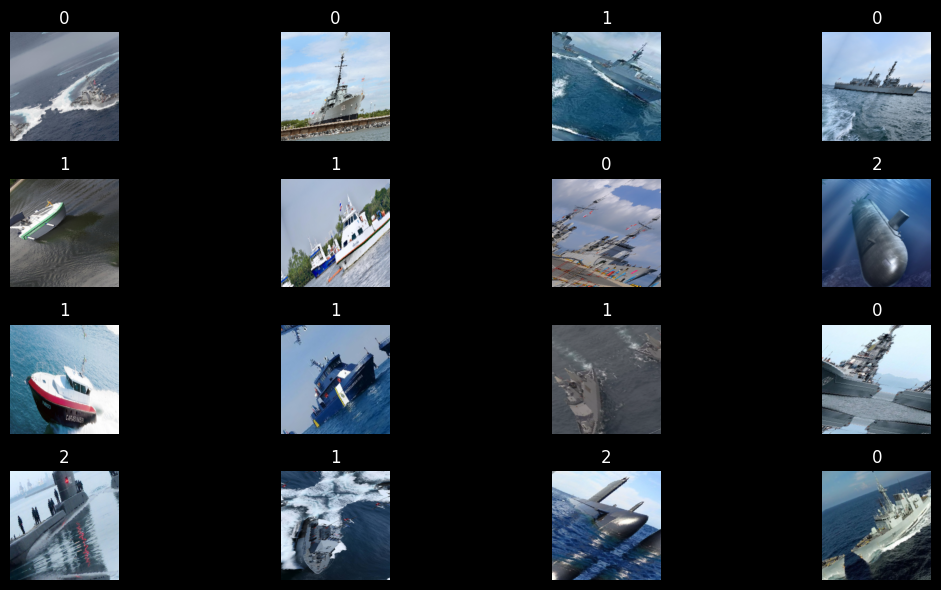

</details>

In [3]:
def imshow_grid(images, labels):
    fig, axes = plt.subplots(4, 4, figsize=(15, 15))
    axes = axes.flatten()
    
    for img, label, ax in zip(images, labels, axes):
        img_np = img.permute(1, 2, 0).numpy()
        ax.imshow(np.clip(img_np, 0, 1))
        ax.set_title(f'{label.item()}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

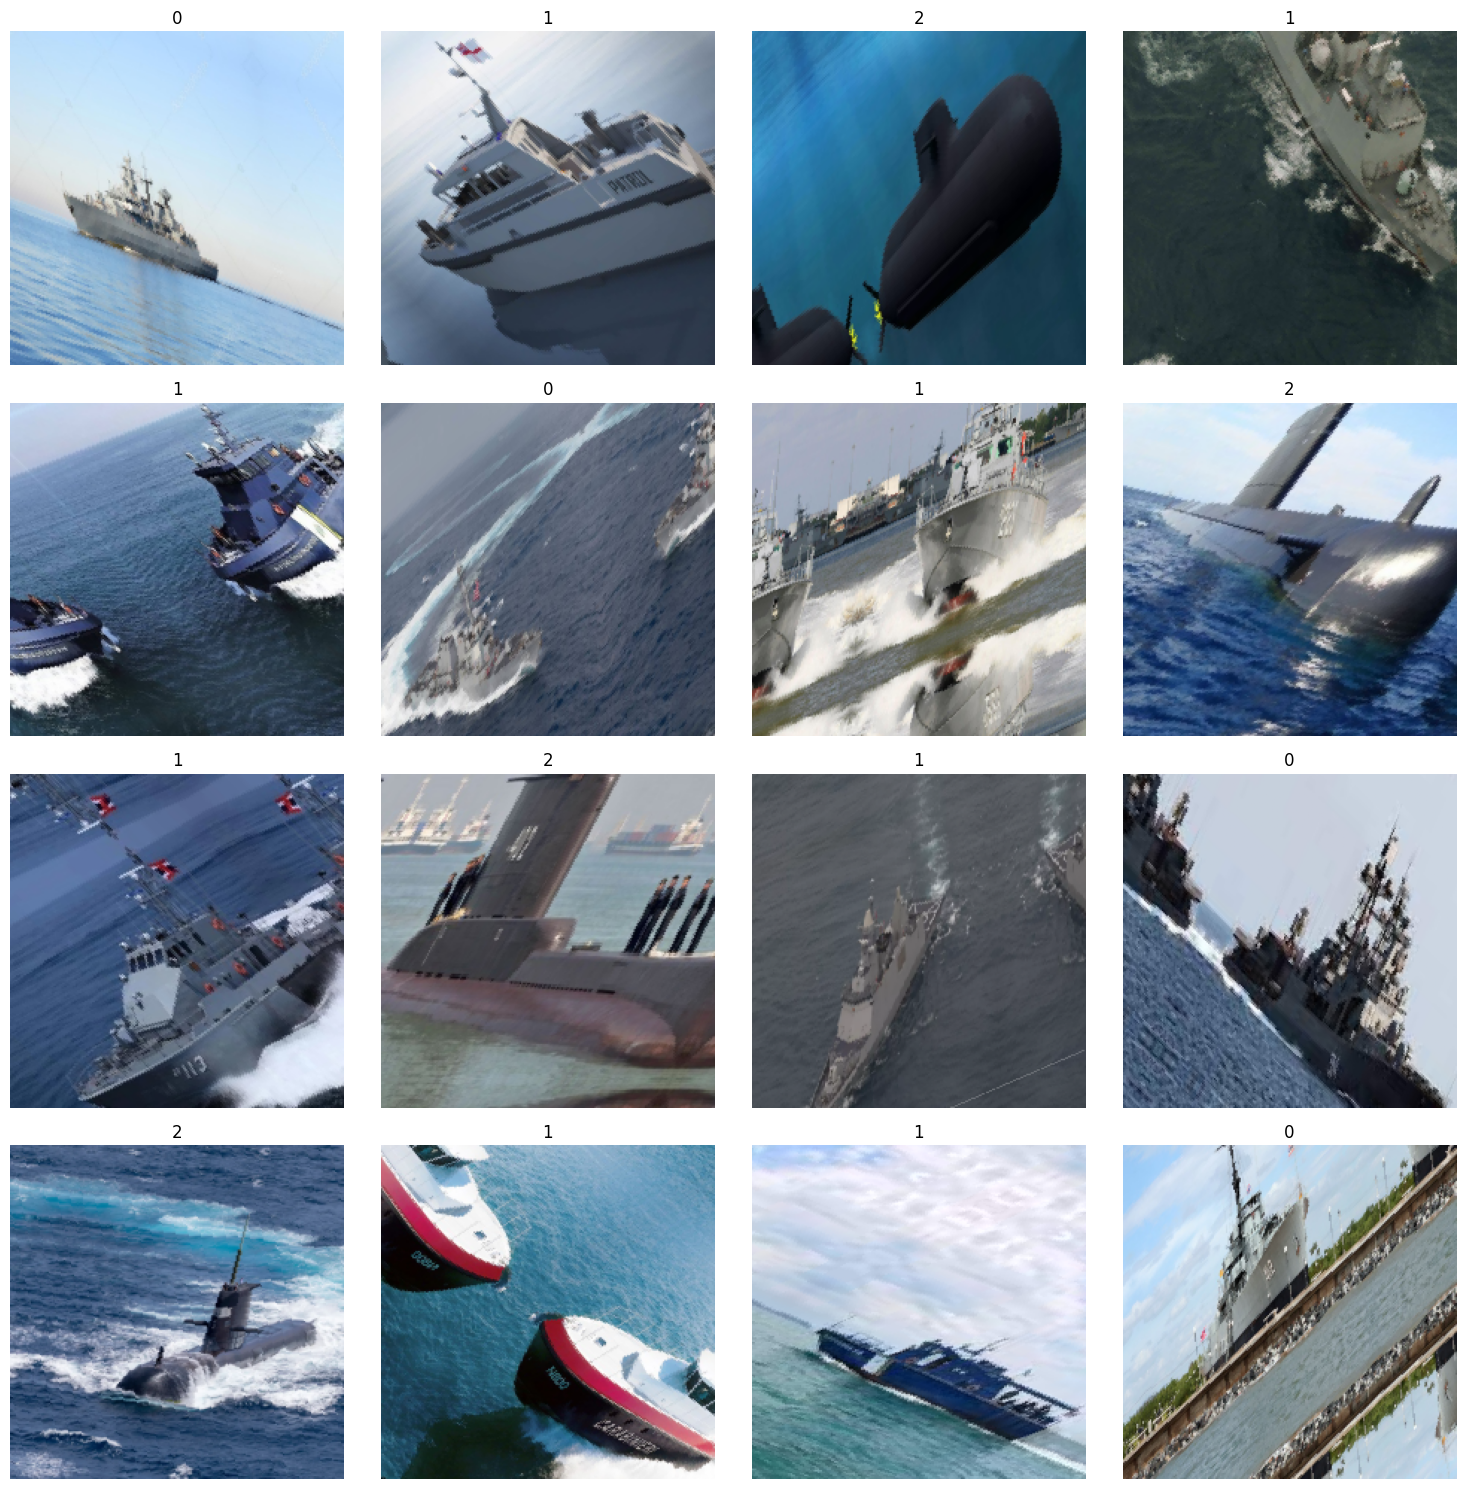

In [4]:
### START CODE HERE ###
data_loader = load_data(r"C:\Users\Nickv\Documents\ImageProcessing\Week7\lab7_1_Ship\Ship\Train")

first_batch = next(iter(data_loader))

images, labels = first_batch

imshow_grid(images, labels)

### END CODE HERE ###

Now, let's create your own `CustomImageDataset` that performs the augmentation as in the previous section, but also includes the methods `add_gaussian_blur()` and `add_gaussian_noise()`. **<font color="red">DO NOT</font>** use `transforms.Compose()`.

Resource : [CustomImageDataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#:~:text=.show()-,Dataset%20class,-torch.utils.data)

In [5]:
### START CODE HERE ###
class CustomImageDataset(Dataset):
    def __init__(self, data_dir, pad=None, padding_mode=None, gauss_noise=False, gauss_blur_ks=None, rotate=None, shear=None, center_crop=None, resize=None, p=0.5):
        self.p = p
        self.resize = resize
        self.pad = pad
        self.padding_mode = padding_mode
        self.gauss_noise = gauss_noise
        self.gauss_blur_ks = gauss_blur_ks
        self.rotate = rotate
        self.shear = shear
        self.center_crop = center_crop
        self.data_dir = data_dir
        self.dataset = ImageFolder(self.data_dir)
        self.image_files = self.dataset.imgs

    def add_gaussian_blur(self, image):
        kernel = random.choice(self.gauss_blur_ks) if self.gauss_blur_ks else 5
        blur_image = cv2.GaussianBlur(image, (kernel, kernel), 0)
        return blur_image
    
    def add_gaussian_noise(self, image):
        noise_image = random_noise(image, var=0.02, mean=0, mode='gaussian')
        return noise_image
    
    def normalize(self, image):
        return (image - image.min()) / (image.max() - image.min())

    def center_crop_image(self, image, size):
        h, w = image.shape[:2]
        startx = w // 2 - (size[1] // 2)
        starty = h // 2 - (size[0] // 2)    
        return image[starty:starty + size[0], startx:startx + size[1]]

    def magic_number(self):
        return random.random() < self.p

    def __getitem__(self, idx):
        image_path, label = self.image_files[idx]
        
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

        if self.gauss_noise:
            image = self.add_gaussian_noise(image)

        if self.gauss_blur_ks:
            image = self.add_gaussian_blur(image)

        if self.resize:
            image = cv2.resize(image, (self.resize, self.resize))

        if self.pad:
            image = cv2.copyMakeBorder(image, self.pad, self.pad, self.pad, self.pad, cv2.BORDER_CONSTANT if self.padding_mode == 'constant' else cv2.BORDER_REFLECT)

        if self.rotate and self.magic_number():
            angle = random.randint(self.rotate[0], self.rotate[1])
            rows, cols, _ = image.shape
            M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
            image = cv2.warpAffine(image, M, (cols, rows))

        if self.center_crop:
            image = self.center_crop_image(image, (self.center_crop, self.center_crop))

        image = self.normalize(image)
        image = torch.from_numpy(image).permute(2, 0, 1).float()

        return image, label
    
    def __len__(self):
        return len(self.image_files)

    
### END CODE HERE ###

Use your `CustomImageDataset()` function. Then, display the image from the first batch.

<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

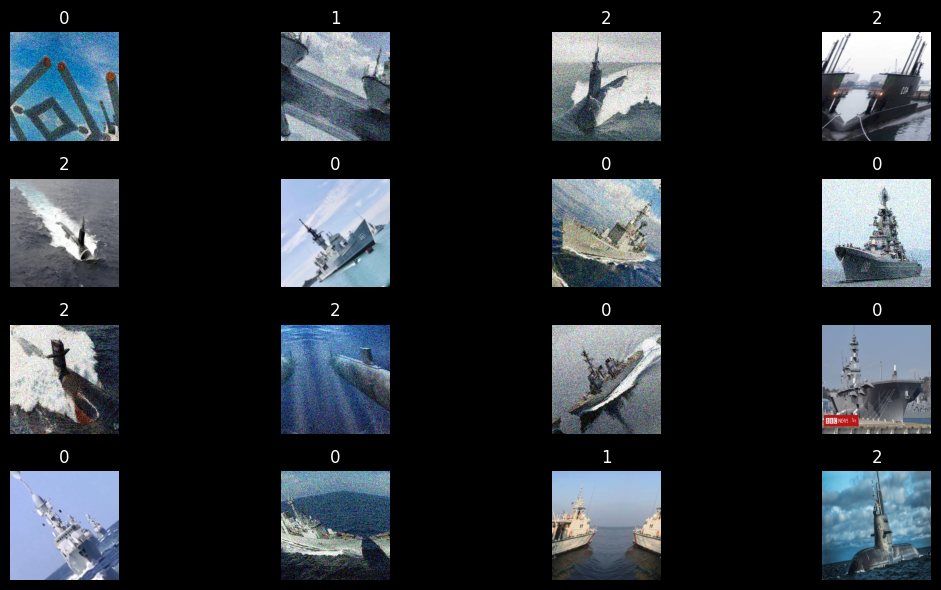

</details>

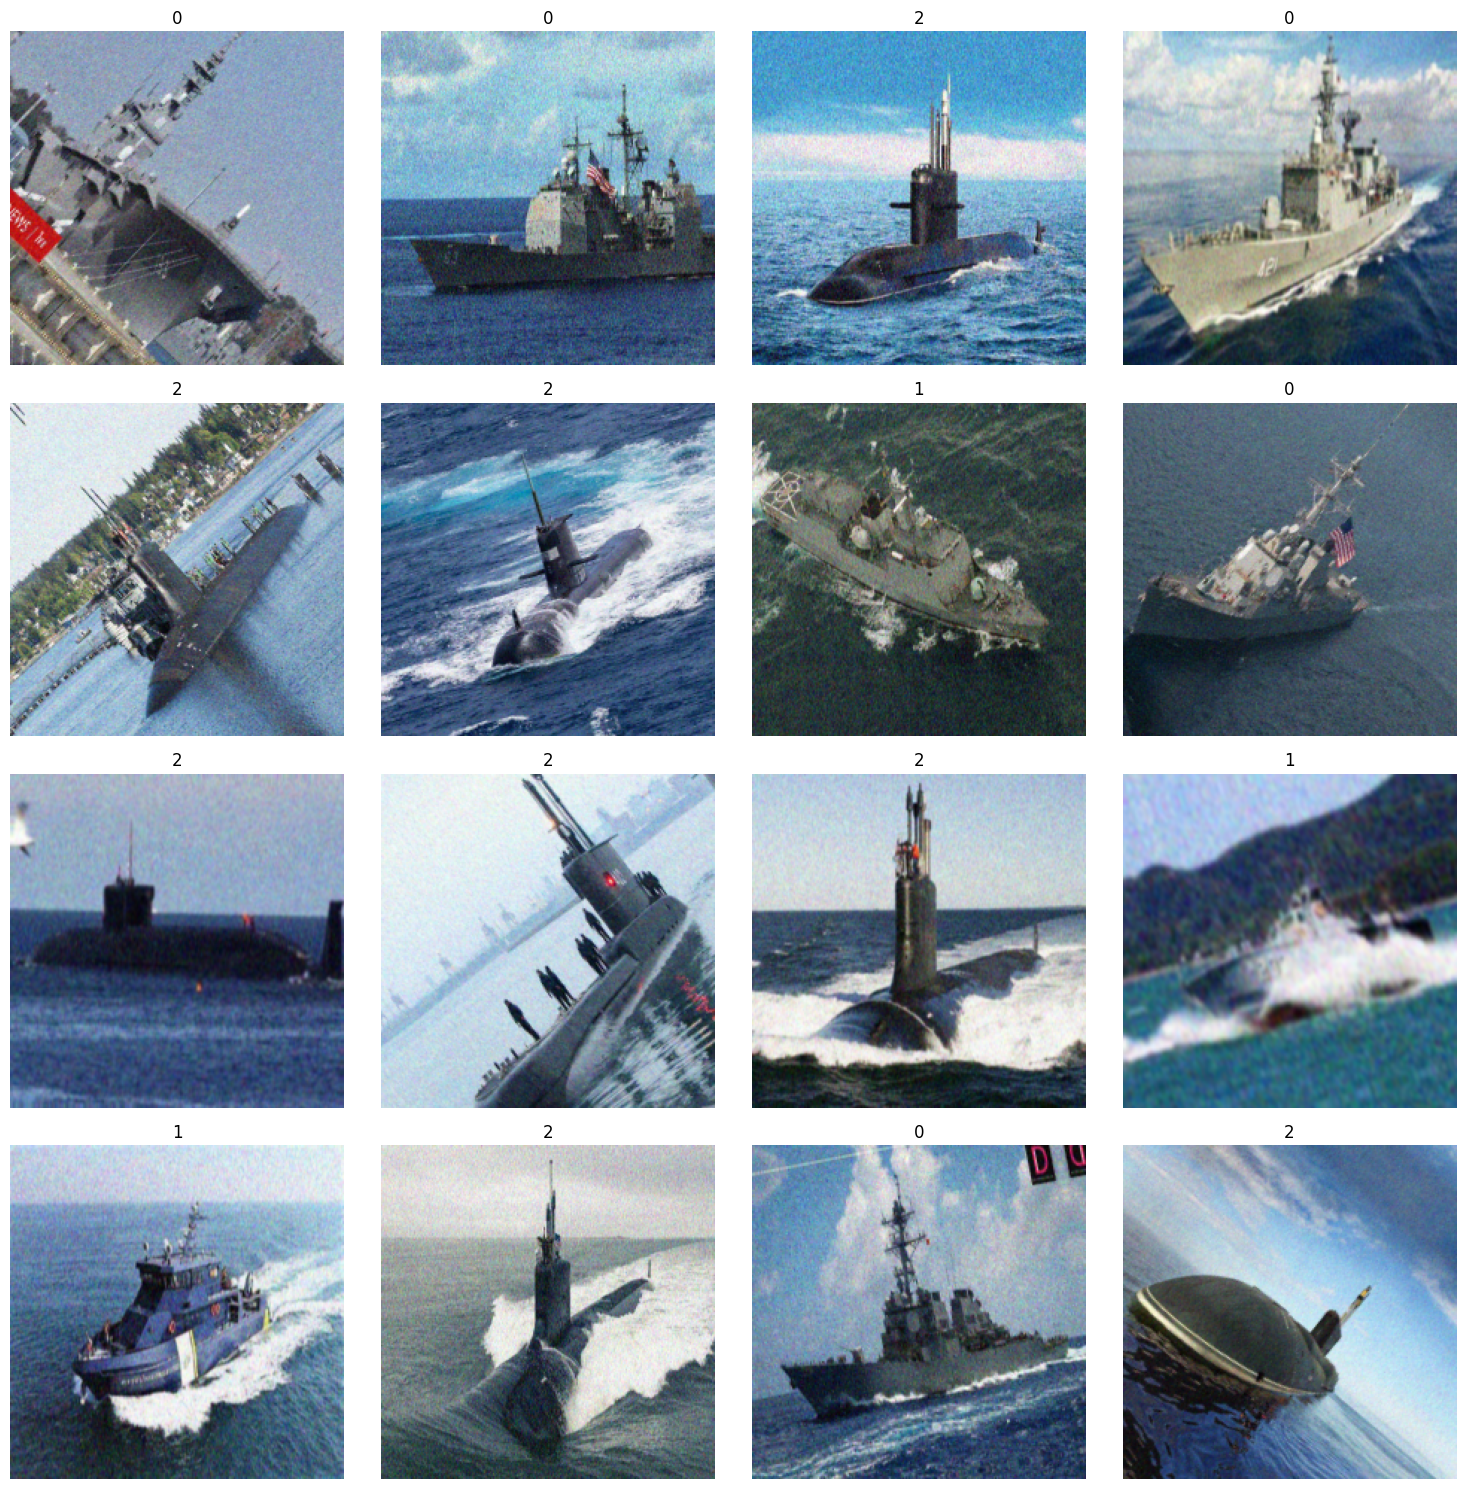

In [6]:
### START CODE HERE ###

data_dir = r'C:\Users\Nickv\Documents\ImageProcessing\Week7\lab7_1_Ship\Ship\Train'
dataset = CustomImageDataset(
    data_dir=data_dir,
    resize=224,
    pad=223,                     
    padding_mode='reflect',    
    gauss_noise=True,          
    gauss_blur_ks=[3, 5, 7],   
    rotate=(-45, 45),         
    center_crop=224,           
    p=0.5    )
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
batch = next(iter(dataloader))
images, labels = batch
imshow_grid(images, labels)

### END CODE HERE ###

---
# Questions
1. Discuss effects and benefits of fill_mode or padding_mode.
2. What would be amount of augmentation should be so that it would not effect the training performance?
3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?
4. What would be transform parameter to simulate camera lense effect?

**1. Discuss effects and benefits of fill_mode or padding_mode.**

- **การรักษาข้อมูลภาพ:** โหมดอย่าง reflect และ nearest ช่วยรักษาโครงสร้างของภาพโดยไม่สร้างขอบที่ไม่เป็นธรรมชาติ ทำให้ภาพที่แปลงแล้วยังคงความสมจริงและความต่อเนื่องที่ขอบ

- **เพิ่มความหลากหลายในการแปลงข้อมูล:** โหมดต่างๆ ช่วยเพิ่มความหลากหลายให้กับข้อมูลที่โมเดลเห็น ทำให้โมเดลมีความแข็งแรงขึ้นและลดการเกิด overfitting

**2. What would be amount of augmentation should be so that it would not effect the training performance?**

- **ความสมดุล:** การทำ augmentation มากเกินไป เช่น การบิดเบือนภาพมากเกินไป อาจทำให้โมเดลเรียนรู้จากข้อมูลที่ไม่เป็นธรรมชาติ ส่งผลเสียต่อความแม่นยำ

- **ความหลากหลายของข้อมูล:** Augmentation ควรเพิ่มความหลากหลายของข้อมูลโดยไม่ทำให้ข้อมูลผิดเพี้ยนจากข้อมูลจริง เช่น การหมุนหรือการเลื่อนภาพเล็กน้อยที่ยังคงโครงสร้างเดิม

**3. How can we create Salt-and-Pepper Noise, which is the type that greatly affect the image quality?**

ในการสร้าง salt_mask และ pepper_mask เราจะสุ่มเลือกตำแหน่งพิกเซลที่ต้องการทำให้เป็น salt และ pepper จากนั้นนำ masks ทั้งสองไปปรับใช้กับภาพเพื่อเพิ่ม Salt-and-Pepper Noise

**4. What would be transform parameter to simulate camera lense effect?**

*GaussianBlur* จะสามารถนำมาปรับใช้ได้โดย การปรับค่าเบลอเพื่อทำให้ภาพมีลักษณะเหมือนถูกเบลอเล็กน้อยที่จุดกลางหรือขอบของภาพ

*RandomAffine* การหมุนภาพเล็กน้อยหรือการเลื่อนภาพเพื่อให้ดูเหมือนว่ามุมมองของกล้องไม่ตรง